In [1]:
# Importing libraries
import numpy as np
from numpy import mean
from numpy import std

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import statsmodels.api as sm
# from patsy import dmatrices
# from statsmodels.stats.outliers_influence import variance_inflation_factor


#Visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from matplotlib.pyplot import xticks
%matplotlib inline

# Data display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

#Sci-kit learn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

#removendo Avisos
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Import data (dados de ranking e dados manuais dos vendedores já removidos)
lead_read = pd.read_csv('C:/Users/mariana.blattner_ifo/Meu Drive/Documentos/Pós/TCC/Base_dados/base_dados.csv', sep=";")

#dropando inputs manuais e scores
col_drop = ['Prospect ID', 'Lead Number', 'Tags', 'Lead Quality', 'Lead Profile', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index','Asymmetrique Activity Score', 'Asymmetrique Profile Score']
lead_read_aux = lead_read.drop(col_drop, axis=1)
lead_read_aux = lead_read_aux.drop('Last Notable Activity', axis=1) #campo com alta correlação

#Substituindo select por nan
lead_nan = lead_read_aux.replace('Select', np.nan)

#Convertendo yes/no pra binário
lead_binario_no = lead_nan.replace('No', 0)
lead_binario_final = lead_binario_no.replace('Yes', 1)

In [4]:
original = lead_read.shape
tratado = lead_binario_final.shape

# lead_read.resume()
# original,tratado

In [5]:
# removendo colunas sem informação (máximo = minimo = 0)
col_drop = ["Magazine", "Receive More Updates About Our Courses","Update me on Supply Chain Content", "Get updates on DM Content", "I agree to pay the amount through cheque"]
lead_drop_colunas = lead_binario_final.drop(col_drop, axis=1) #index 0 deleta linha, index 1 deleta coluna


#removendo linhas sem dados da visita ----fora de uso, vou usar valorew mais comuns e medianas pra tratar esses dados
# lead_drop_linhas = lead_drop_colunas.loc[(lead_drop_colunas["TotalVisits"] >= 0) ]
# lead_drop_colunas.shape, lead_drop_linhas.shape

In [6]:
#tratando NAN
#Column wise null values in train data set 
perc_null = lead_binario_final
round(100*perc_null.isnull().sum()/perc_null.shape[0],0) , perc_null.shape

(Lead Origin                                       0.0
 Lead Source                                       0.0
 Do Not Email                                      0.0
 Do Not Call                                       0.0
 Converted                                         0.0
 TotalVisits                                       1.0
 Total Time Spent on Website                       0.0
 Page Views Per Visit                              1.0
 Last Activity                                     1.0
 Country                                          27.0
 Specialization                                   37.0
 How did you hear about X Education               78.0
 What is your current occupation                  29.0
 What matters most to you in choosing a course    29.0
 Search                                            0.0
 Magazine                                          0.0
 Newspaper Article                                 0.0
 X Education Forums                                0.0
 Newspaper

In [7]:
# columa "How did you hear about X Education" possui 78% dos dados NANe será dropada
col_drop = ["How did you hear about X Education"]
lead_drop_colunas_NAN = lead_drop_colunas.drop(col_drop, axis=1) #index 0 deleta linha, index 1 deleta coluna

# colunas categóricas trarão mediada, colunas numéricas o valor mais frequente
# https://medium.com/data-hackers/tratamento-e-transforma%C3%A7%C3%A3o-de-dados-nan-uma-vis%C3%A3o-geral-e-pr%C3%A1tica-54efa9fc7a98
col_numerica = ["TotalVisits","Page Views Per Visit"]
col_categoricas = ["Last Activity","City","Country","Specialization","What is your current occupation","What matters most to you in choosing a course"]

#função tratar NAN
median_imputer=SimpleImputer(missing_values=np.nan,strategy='median')
most_imputer=SimpleImputer(missing_values=np.nan,strategy='most_frequent')

lead_tratandoNAN = lead_drop_colunas_NAN
lead_tratandoNAN[col_numerica]=median_imputer.fit_transform(lead_tratandoNAN[col_numerica])
lead_tratandoNAN[col_categoricas]=most_imputer.fit_transform(lead_tratandoNAN[col_categoricas])

perc_null = lead_tratandoNAN
round(100*perc_null.isnull().sum()/perc_null.shape[0],0) , perc_null.shape

(Lead Origin                                      0.0
 Lead Source                                      0.0
 Do Not Email                                     0.0
 Do Not Call                                      0.0
 Converted                                        0.0
 TotalVisits                                      0.0
 Total Time Spent on Website                      0.0
 Page Views Per Visit                             0.0
 Last Activity                                    0.0
 Country                                          0.0
 Specialization                                   0.0
 What is your current occupation                  0.0
 What matters most to you in choosing a course    0.0
 Search                                           0.0
 Newspaper Article                                0.0
 X Education Forums                               0.0
 Newspaper                                        0.0
 Digital Advertisement                            0.0
 Through Recommendations    

In [8]:
# padronização das variáveis
col_padronizar = ['Total Time Spent on Website','Page Views Per Visit','TotalVisits']

#função padronizar
scaler = StandardScaler()

lead_padronizada = lead_tratandoNAN
lead_padronizada[col_padronizar] = scaler.fit_transform(lead_tratandoNAN[col_padronizar])

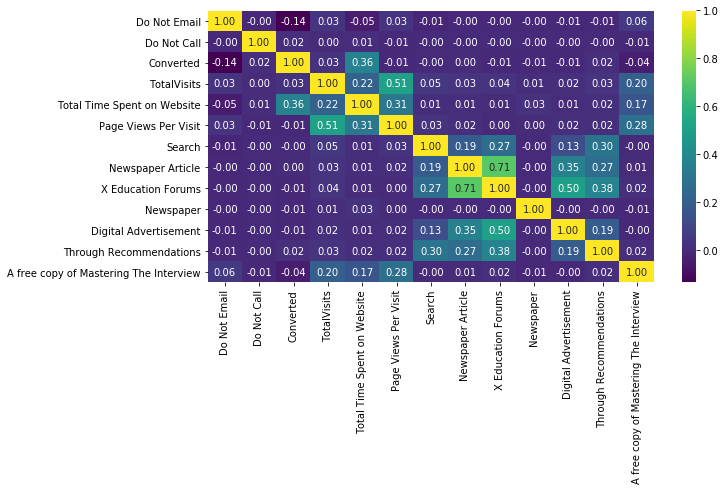

In [9]:
# matriz de correlação
plt.figure(figsize = (10,5))
sns.heatmap(lead_padronizada.corr(), annot = True, cmap="viridis", fmt=".2f")
plt.show()

In [10]:
# criando dummies
# removendo cidade e pais pra tentar rodar teste
dummy = pd.get_dummies(lead_padronizada[['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization', 'What is your current occupation', 'What matters most to you in choosing a course']], drop_first=True)
# dummy = pd.get_dummies(lead_padronizada[['Lead Origin', 'Lead Source', 'Last Activity', 'City', 'Country', 'Specialization', 'What is your current occupation', 'What matters most to you in choosing a course']], drop_first=True)


# add na base
lead_dummies_aux = pd.concat([lead_padronizada, dummy], axis=1)

# deletando colunas originais
lead_dummies = lead_dummies_aux.drop(['Lead Origin', 'Lead Source', 'Last Activity', 'City', 'Country', 'Specialization', 'What is your current occupation', 'What matters most to you in choosing a course'], axis=1)
# lead_dummies.head()

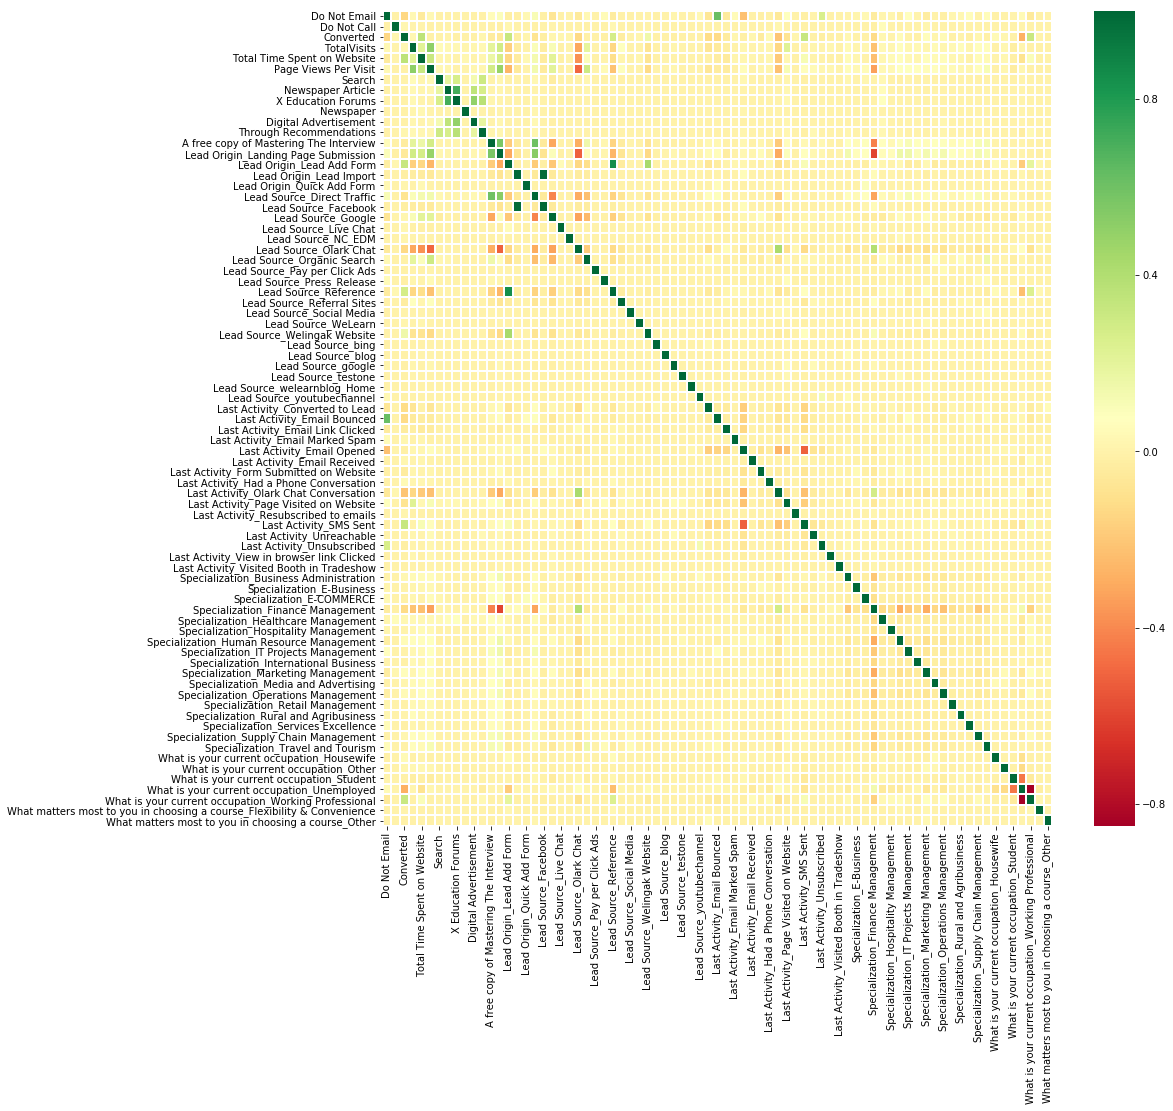

In [11]:
# matriz de correlação
# plt.figure(figsize = (15,15))
# sns.heatmap(lead_dummies.corr(), cmap="viridis_r", linewidth =1)
# plt.show()

plt.figure(figsize=[15,15])
sns.heatmap(lead_dummies.corr(), cmap="RdYlGn",linewidth =1)
plt.show()

In [12]:
#verificando top correlações (mapa calor ficou com muitas colunas)

corr_lead = lead_dummies.corr()
corr_lead = corr_lead.where(np.triu(np.ones(corr_lead.shape),k=1).astype(np.bool))
corr_df = corr_lead.unstack().reset_index()
corr_df.columns =['VAR1','VAR2','Correlation']
corr_df.dropna(subset = ["Correlation"], inplace = True) 

#top 10 positivas 
corr_df.sort_values(by='Correlation', ascending=False, inplace=True)
# corr_df.head(10)

In [13]:
# drop em uma das features com correlações acima de 50%
# vamos deletar a que tiver a menos correlação com "converted"

# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Lead Source_Facebook")] -0.023695 drop
# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Lead Origin_Lead Import")] -0.023695

# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Lead Source_Reference")] 0.27083 drop 
# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Lead Origin_Lead Add Form")] 0.321702

# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "X Education Forums")] -0.008238
# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Newspaper Article")] 0.003465 drop

# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Last Activity_Email Bounced")]  -0.120095
# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Do Not Email")] ??? drop

# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Lead Source_Direct Traffic")]  -0.080682
# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "A free copy of Mastering The Interview")] -0.03982 drop

# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Lead Origin_Landing Page Submission")] -0.051236
# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "A free copy of Mastering The Interview")]  -0.03982 drop

# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Lead Source_Direct Traffic")] -0.080682
# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Lead Origin_Landing Page Submission")] -0.051236 drop

# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Page Views Per Visit")] -0.005068 drop
# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "TotalVisits")] 0.029119

In [14]:
#top 10 negativas 
corr_df.sort_values(by='Correlation', ascending=True, inplace=True)
# corr_df.head(10)

In [15]:
# drop em uma das features com correlações acima de -50%
# vamos deletar a que tiver a menor correlação com "converted"

# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "What is your current occupation_Working Professional")] 0.313837
# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "What is your current occupation_Unemployed")]  -0.281065 drop

# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Specialization_Finance Management")] -0.121951
# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Lead Origin_Landing Page Submission")] -0.051236 drop

# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Lead Source_Olark Chat")] -0.129459
# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Lead Origin_Landing Page Submission")]  	-0.051236 drop

# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Last Activity_SMS Sent")] 0.3256
# corr_df[(corr_df.VAR2 == 'Converted') & (corr_df.VAR1 == "Last Activity_Email Opened")] -0.01385 drop

In [16]:
# https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/
# We need to set an absolute value, say 0.5 as the threshold for selecting the variables. 
# If we find that the predictor variables are correlated among themselves, we can drop the variable which has a 
# lower correlation coefficient value with the target variable. We can also compute multiple correlation 
# coefficients to check whether more than two variables are correlated to each other. 
# This phenomenon is known as multicollinearity.

# deletando colunas das correlações 
lead_dummies_correlacao_final = lead_dummies.drop(["Lead Source_Facebook",
"Newspaper Article",
"Do Not Email",
"A free copy of Mastering The Interview",
"Lead Origin_Landing Page Submission",
"Page Views Per Visit",
"What is your current occupation_Unemployed",
"Last Activity_Email Opened"], axis=1)

# lead_dummies_correlacao_final.head()


In [17]:
lead_dummies_correlacao_final.shape

(9240, 69)

# Selecionando features

In [19]:
#RFE
# https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

# Feature selection methods are intended to reduce the number of input variables to those that are believed to be most useful to a model in order to predict the target variable.

# Some predictive modeling problems have a large number of variables that can slow the development and training of models and require a large amount of system memory. Additionally, the performance of some models can degrade when including input variables that are not relevant to the target variable.
# Many models, especially those based on regression slopes and intercepts, will estimate parameters for every term in the model. Because of this, the presence of non-informative variables can add uncertainty to the predictions and reduce the overall effectiveness of the model.
# — Page 488, Applied Predictive Modeling, 2013.
# https://amzn.to/3b2LHTL

In [20]:
#RFE
lead = lead_dummies_correlacao_final
y = lead['Converted']
X = lead.drop(['Converted'], axis=1)

# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

# Rodando RFE com reg logística
# The algorithm must provide a way to calculate important scores, such as a decision tree. 
# The algorithm used in RFE does not have to be the algorithm that is fit on the selected features; different algorithms can be used.

logreg = LogisticRegression()
rfe = RFE(estimator=logreg, n_features_to_select=30)           
rfe = rfe.fit(X_train, y_train)

In [21]:
# # https://machinelearningmastery.com/rfe-feature-selection-in-python/
    
# # explore the number of selected features for RFE
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.feature_selection import RFE
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
# from matplotlib import pyplot 

# # get a list of models to evaluate
# def get_models():
#     models = dict()
#     for i in range(10, 40):
#         rfe = RFE(estimator=logreg, n_features_to_select=i)
#         model = logreg
#         models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
#     return models
 
# # evaluate a give model using cross-validation
# def evaluate_model(model, X, y):
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#     return scores
 
# # get the models to evaluate
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
#     print('rodando %s features' % (name))
#     scores = evaluate_model(model, X, y)
#     results.append(scores)
#     names.append(name)
#     print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()

In [22]:
# # https://machinelearningmastery.com/rfe-feature-selection-in-python/
# # We will evaluate the model using repeated stratified k-fold cross-validation, with three repeats and 10 folds. 
# # We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.

# # create pipeline
# pipeline = Pipeline(steps=[('s',rfe),('m',logreg)])

# # evaluate model
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# # report performance
# print('Acurácia usando 20 features: %.2f (%.2f)' % (mean(n_scores), std(n_scores)))

# # Acurácia usando 30 features: 0.80 (0.01)
# # Acurácia usando 20 features: 0.80 (0.01)
# # Acurácia usando 10 features: 0.80 (0.02)

In [48]:
#verificando features
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Call', True, 1),
 ('TotalVisits', False, 32),
 ('Total Time Spent on Website', True, 1),
 ('Search', False, 8),
 ('X Education Forums', False, 17),
 ('Newspaper', True, 1),
 ('Digital Advertisement', True, 1),
 ('Through Recommendations', True, 1),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', True, 1),
 ('Lead Origin_Quick Add Form', False, 14),
 ('Lead Source_Direct Traffic', True, 1),
 ('Lead Source_Google', False, 4),
 ('Lead Source_Live Chat', False, 12),
 ('Lead Source_NC_EDM', True, 1),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 3),
 ('Lead Source_Pay per Click Ads', False, 19),
 ('Lead Source_Press_Release', True, 1),
 ('Lead Source_Reference', True, 1),
 ('Lead Source_Referral Sites', False, 2),
 ('Lead Source_Social Media', True, 1),
 ('Lead Source_WeLearn', False, 9),
 ('Lead Source_Welingak Website', True, 1),
 ('Lead Source_bing', False, 29),
 ('Lead Source_blog', False, 6),
 ('Lead Source_google', True, 1

In [49]:
#verificando features selecionadas
col = X_train.columns[rfe.support_]

#verificando features não selecionadas
# X_train.columns[~rfe.support_]

In [50]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial()) #Logistic regression used mostly for binary classification problems.
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6437
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2729.9
Date:                Wed, 12 Apr 2023   Deviance:                       5459.8
Time:                        00:00:58   Pearson chi2:                 9.48e+03
No. Iterations:                    22   Covariance Type:             nonrobust
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.1633      0.065    -18.035      0.000      -1.290      -1.037
Do Not Call                                             23.2909   5.42e+04      0.000      1.000   -1.06e+05    1.06e+05
Total Time Spent on Website                              1.1014      0.039     28.108      0.000       1.025       1.178
Newspaper                                              -24.7237   7.95e+04     -0.000      1.000   -1.56e+05    1.56e+05
Digital Advertisement                                  -22.9551   4.48e+04     -0.001      1.000   -8.78e+04    8.77e+04
Through Recommendations                                  1.4369      1.448      0.993      0.321      -1.400       4.274
Lead Origin_Lead Add Form                                2.9165      0.475      6.144      0.000       1.986       3.847
Lead Origin_Lead Import                                 -0.4162      0.527     -0.790      0.430      -1.449       0.617
Lead Source_Direct Traffic                              -0.3407      0.082     -4.176      0.000      -0.501      -0.181
Lead Source_NC_EDM                                      23.8384   7.95e+04      0.000      1.000   -1.56e+05    1.56e+05
Lead Source_Olark Chat                                   1.0412      0.105      9.952      0.000       0.836       1.246
Lead Source_Press_Release                              -22.5979   5.16e+04     -0.000      1.000   -1.01e+05    1.01e+05
Lead Source_Reference                                    0.6037      0.509      1.186      0.236      -0.394       1.601
Lead Source_Social Media                                 2.1268      1.437      1.481      0.139      -0.689       4.942
Lead Source_Welingak Website                             2.5016      0.865      2.893      0.004       0.807       4.196
Lead Source_google                                     -22.5865   3.23e+04     -0.001      0.999   -6.34e+04    6.34e+04
Last Activity_Converted to Lead                         -1.3284      0.220     -6.049      0.000      -1.759      -0.898
Last Activity_Email Bounced                             -2.0242      0.294     -6.897      0.000      -2.599      -1.449
Last Activity_Email Link Clicked                        -0.6045      0.222     -2.721      0.007      -1.040      -0.169
Last Activity_Form Submitted on Website                 -0.7477      0.339     -2.203      0.028      -1.413      -0.082
Last Activity_Had a Phone Conversation                   1.9946      0.660      3.023      0.003       0.701       3.288
Last Activity_Olark Chat Conversation                   -1.5585      0.166     -9.382      0.000      -1.884      -1.233
Last Activity_Page Visited on Website                   -0.6309      0.145     -4.345      0.000      -0.916      -0.346
Last Activity_Re

In [51]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [47]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,Lead Origin_Lead Add Form,15.84
11,Lead Source_Reference,12.98
13,Lead Source_Welingak Website,3.77
9,Lead Source_Olark Chat,1.61
20,Last Activity_Olark Chat Conversation,1.38
23,Last Activity_SMS Sent,1.32
7,Lead Source_Direct Traffic,1.29
1,Total Time Spent on Website,1.23
29,What is your current occupation_Working Profes...,1.18
21,Last Activity_Page Visited on Website,1.07


In [54]:
col_final = [
'Lead Source_Olark Chat',
'Lead Origin_Lead Add Form',
'Last Activity_Olark Chat Conversation',
'Lead Source_Welingak Website',
'Total Time Spent on Website',
'Last Activity_SMS Sent',
'What is your current occupation_Working Professional',
'Last Activity_Email Link Clicked',
'Last Activity_Email Bounced',
'Last Activity_Had a Phone Conversation',
'Last Activity_Page Visited on Website',
'Specialization_Hospitality Management',
'Last Activity_Converted to Lead',
'Last Activity_Form Submitted on Website'
]


In [58]:
X_train_sm = sm.add_constant(X_train[col_final])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
# res.summary()

In [ ]:
# VIF e p-valor ok
# Inferences:
# We have a stable model where all P-values of features are significant and VIF values are below 3
# signifiying that there is negligible multi-colinearity. 

In [57]:
# How many features in the model ?
len(col_final)

14

# Treinando o modelo

In [59]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)     #serie
y_train_pred = y_train_pred.values.reshape(-1)    #convertendo em array

In [60]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_prob':y_train_pred})
y_train_pred_final.head(10)

,Converted,Converted_prob
0,0,0.248945
1,0,0.217971
2,0,0.290858
3,0,0.776128
4,0,0.248945
5,1,0.990483
6,0,0.110522
7,1,0.999011
8,0,0.123502
9,1,0.871296


In [61]:
# Jogando 50% como corte 
# Creating new column 'predicted' with 1 if Converted_Prob > 0.50 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.50 else 0)
y_train_pred_final.head(10)

,Converted,Converted_prob,predicted
0,0,0.248945,0
1,0,0.217971,0
2,0,0.290858,0
3,0,0.776128,1
4,0,0.248945,0
5,1,0.990483,1
6,0,0.110522,0
7,1,0.999011,1
8,0,0.123502,0
9,1,0.871296,1


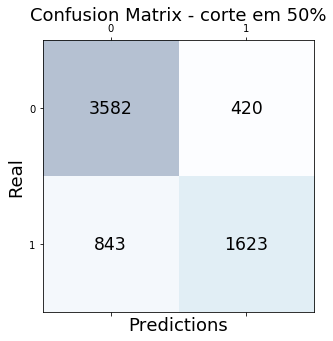

In [62]:
#Plotting the Confusion Matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(x=j, y=i,s=confusion[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Real', fontsize=18)
plt.title('Confusion Matrix - corte em 50%', fontsize=18)
plt.show()


In [63]:
# Create a matrix to Print the Accuracy, Sensitivity and Specificity
def lg_metrics(confusion_matrix):
    TN =confusion_matrix[0,0]
    TP =confusion_matrix[1,1]
    FP =confusion_matrix[0,1]
    FN =confusion_matrix[1,0]
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    speci = TN/(TN+FP)
    sensi = TP/(TP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN) #revocação
    TPR = TP/(TP + FN)
    TNR = TN/(TN + FP)
    FPR = FP/(TN + FP)
    FNR = FN/(TP + FN)
    pos_pred_val = TP /(TP+FP)
    neg_pred_val = TN /(TN+FN)
    testF1_score= 2 * (precision * recall) / (precision + recall)
    
    print ("Accuracy:    ", round(accuracy*100,2),"%")
    print ("Sensitivity: ", round(sensi*100,2),"%")
    print ("Specificity: ", round(speci*100,2),"%")
    print ("Precision:   ", round(precision*100,2),"%")
    print ("Recall:      ", round(recall*100,2),"%")
    print ("F1 Score:    ", round(testF1_score*100,2),"%")
    print ("")
    print ("True Positive Rate (TP):  ", round(TPR*100,2),"%")
    print ("False Positive Rate (FP): ", round(FPR*100,2),"%")
    print ("")
    print ("True Negative Rate (TN):  ", round(TNR*100,2),"%")
    print ("False Negative Rate (FN): ", round(FNR*100,2),"%")
    print ("")    
    print ("Positive predictive value: ", round(pos_pred_val*100,2),"%")
    print ("Negative predictive value: ", round(neg_pred_val*100,2),"%")
    
# Plotando tabela
conf_matrix1 = confusion_matrix(y_train_pred_final['Converted'], y_train_pred_final['predicted'] )
lg_metrics(conf_matrix1)



Accuracy:     80.47 %
Sensitivity:  65.82 %
Specificity:  89.51 %
Precision:    79.44 %
Recall:       65.82 %
F1 Score:     71.99 %

True Positive Rate (TP):   65.82 %
False Positive Rate (FP):  10.49 %

True Negative Rate (TN):   89.51 %
False Negative Rate (FN):  34.18 %

Positive predictive value:  79.44 %
Negative predictive value:  80.95 %


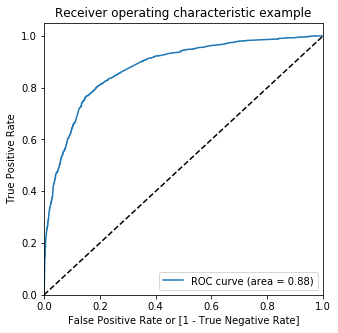

In [64]:
# Plotting the ROC Curve
# An ROC curve demonstrates several things:

# It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by 
# a decrease in specificity).
# The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
# The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.


def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None


fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final.Converted, 
                                         y_train_pred_final.Converted_prob, drop_intermediate = False )

draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

In [65]:
# Finding Optimal Cutoff Point
# Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.248945,0,1,1,1,0,0,0,0,0,0,0
1,0,0.217971,0,1,1,1,0,0,0,0,0,0,0
2,0,0.290858,0,1,1,1,0,0,0,0,0,0,0
3,0,0.776128,1,1,1,1,1,1,1,1,1,0,0
4,0,0.248945,0,1,1,1,0,0,0,0,0,0,0


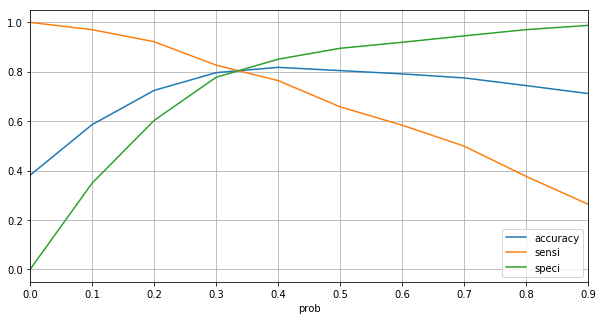

In [66]:
# Calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
# print(cutoff_df)

# Plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'],figsize = (10,5))
plt.grid(True)
plt.show()

In [67]:
## Ponto ótimo fica próximo de 0.33, ele será o novo corte
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_prob.map( lambda x: 1 if x > 0.33 else 0)
y_train_pred_final.head()

,Converted,Converted_prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.248945,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0.217971,0,1,1,1,0,0,0,0,0,0,0,0
2,0,0.290858,0,1,1,1,0,0,0,0,0,0,0,0
3,0,0.776128,1,1,1,1,1,1,1,1,1,0,0,1
4,0,0.248945,0,1,1,1,0,0,0,0,0,0,0,0


In [68]:
# Assigning Lead Score
y_train_pred_final['Lead_Score'] = y_train_pred_final.Converted_prob.map( lambda x: round(x*100))
y_train_pred_final.head()

,Converted,Converted_prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,Lead_Score
0,0,0.248945,0,1,1,1,0,0,0,0,0,0,0,0,25
1,0,0.217971,0,1,1,1,0,0,0,0,0,0,0,0,22
2,0,0.290858,0,1,1,1,0,0,0,0,0,0,0,0,29
3,0,0.776128,1,1,1,1,1,1,1,1,1,0,0,1,78
4,0,0.248945,0,1,1,1,0,0,0,0,0,0,0,0,25


In [69]:
y_train_pred_final.tail()

,Converted,Converted_prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,Lead_Score
6463,1,0.793331,1,1,1,1,1,1,1,1,1,0,0,1,79
6464,1,0.991215,1,1,1,1,1,1,1,1,1,1,1,1,99
6465,1,0.248945,0,1,1,1,0,0,0,0,0,0,0,0,25
6466,0,0.042320,0,1,0,0,0,0,0,0,0,0,0,0,4
6467,0,0.248945,0,1,1,1,0,0,0,0,0,0,0,0,25


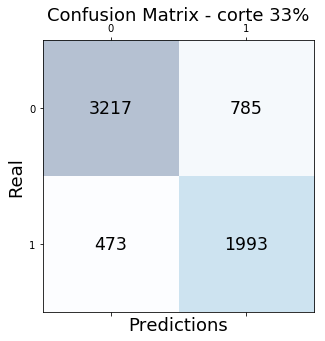

In [70]:
#Plotting the Confusion Matrix 
conf_matrix = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Real', fontsize=18)
plt.title('Confusion Matrix - corte 33%', fontsize=18)
plt.show()

In [71]:
#Print the Accuracy, Sensitivity and Specificity
conf_matrix = confusion_matrix(y_train_pred_final['Converted'], y_train_pred_final['final_predicted'] )
lg_metrics(conf_matrix)

Accuracy:     80.55 %
Sensitivity:  80.82 %
Specificity:  80.38 %
Precision:    71.74 %
Recall:       80.82 %
F1 Score:     76.01 %

True Positive Rate (TP):   80.82 %
False Positive Rate (FP):  19.62 %

True Negative Rate (TN):   80.38 %
False Negative Rate (FN):  19.18 %

Positive predictive value:  71.74 %
Negative predictive value:  87.18 %


# Teste - (avaliando o treino)

In [72]:
X_test.head()

,Do Not Call,TotalVisits,Total Time Spent on Website,Search,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_google,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Working Professional,What matters most to you in choosing a course_Flexibility & Convenience,What matters most to you in choosing a course_Other
4269,0,0.946584,0.954944,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2376,0,-0.713593,-0.889974,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7766,0,0.324018,-0.782308,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
9199,0,-0.713593,-0.889974,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4359,0,-0.713593,-0.889974,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [82]:
# Selecting only the columns used in final model of Train Dataset
X_test = X_test[col_final]
X_test.head()

,Lead Source_Olark Chat,Lead Origin_Lead Add Form,Last Activity_Olark Chat Conversation,Lead Source_Welingak Website,Total Time Spent on Website,Last Activity_SMS Sent,What is your current occupation_Working Professional,Last Activity_Email Link Clicked,Last Activity_Email Bounced,Last Activity_Had a Phone Conversation,Last Activity_Page Visited on Website,Specialization_Hospitality Management,Last Activity_Converted to Lead,Last Activity_Form Submitted on Website
4269,0,0,0,0,0.954944,1,0,0,0,0,0,0,0,0
2376,0,1,0,0,-0.889974,1,0,0,0,0,0,0,0,0
7766,0,0,0,0,-0.782308,0,1,0,0,0,0,0,0,0
9199,1,0,1,0,-0.889974,0,0,0,0,0,0,0,0,0
4359,0,1,0,0,-0.889974,0,0,0,0,0,0,0,0,0


In [85]:
#adding contant value
X_test_sm = sm.add_constant(X_test)
X_test_sm.columns

Index(['const', 'Lead Source_Olark Chat', 'Lead Origin_Lead Add Form',
       'Last Activity_Olark Chat Conversation', 'Lead Source_Welingak Website',
       'Total Time Spent on Website', 'Last Activity_SMS Sent',
       'What is your current occupation_Working Professional',
       'Last Activity_Email Link Clicked', 'Last Activity_Email Bounced',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Page Visited on Website',
       'Specialization_Hospitality Management',
       'Last Activity_Converted to Lead',
       'Last Activity_Form Submitted on Website'],
      dtype='object')

In [87]:
# Predicting the final test model 
y_test_pred = res.predict(X_test_sm)

In [88]:
# Converting y_pred to a dataframe which is an array
y_test_pred = pd.DataFrame(y_test_pred)
# y_test_pred.head()

In [89]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
# y_test_df.head()

In [90]:
# Putting CustID to index
y_test_df['Prospect_IND'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_test_pred.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_test_pred],axis=1)
# y_pred_final.head()

In [91]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})
y_pred_final= y_pred_final.rename(columns={ 'Converted' : 'Converted_IND'})

# Rearranging the columns
y_pred_final = y_pred_final.reindex(['Prospect_IND','Converted_IND','Converted_Prob'], axis=1)
# y_pred_final.head()

In [92]:
#Aplicando o corte de 33%
y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.335 else 0)
y_pred_final.head()

,Prospect_IND,Converted_IND,Converted_Prob,final_predicted
0,4269,1,0.690641,1
1,2376,1,0.914721,1
2,7766,1,0.672070,1
3,9199,0,0.068073,0
4,4359,1,0.793331,1


In [93]:
#Print the Accuracy, Sensitivity and Specificity
conf_matrix = confusion_matrix(y_pred_final['Converted_IND'], y_pred_final['final_predicted'])
lg_metrics(conf_matrix)

Accuracy:     80.16 %
Sensitivity:  79.18 %
Specificity:  80.8 %
Precision:    72.92 %
Recall:       79.18 %
F1 Score:     75.92 %

True Positive Rate (TP):   79.18 %
False Positive Rate (FP):  19.2 %

True Negative Rate (TN):   80.8 %
False Negative Rate (FN):  20.82 %

Positive predictive value:  72.92 %
Negative predictive value:  85.6 %


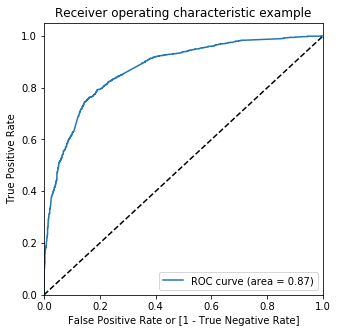

In [94]:
# ROC curve
draw_roc( y_pred_final['Converted_IND'], y_pred_final['Converted_Prob'])

# Olhando features

In [95]:
# Let's look into final model features and coefficients 
pd.options.display.float_format = '{:.2f}'.format
final_parameters = res.params[1:]
final_parameters

Lead Source_Olark Chat                                  1.15
Lead Origin_Lead Add Form                               3.60
Last Activity_Olark Chat Conversation                  -1.51
Lead Source_Welingak Website                            1.94
Total Time Spent on Website                             1.10
Last Activity_SMS Sent                                  1.03
What is your current occupation_Working Professional    2.86
Last Activity_Email Link Clicked                       -0.58
Last Activity_Email Bounced                            -2.09
Last Activity_Had a Phone Conversation                  2.03
Last Activity_Page Visited on Website                  -0.65
Specialization_Hospitality Management                  -0.89
Last Activity_Converted to Lead                        -1.34
Last Activity_Form Submitted on Website                -0.65
dtype: float64

In [96]:
#Getting a relative coeffient value for all the features wrt the feature with the highest coefficient

top_predictors = final_parameters
top_predictors = 100.0 * (top_predictors / top_predictors.max())
top_predictors

Lead Source_Olark Chat                                  31.99
Lead Origin_Lead Add Form                              100.00
Last Activity_Olark Chat Conversation                  -42.00
Lead Source_Welingak Website                            53.81
Total Time Spent on Website                             30.58
Last Activity_SMS Sent                                  28.53
What is your current occupation_Working Professional    79.28
Last Activity_Email Link Clicked                       -16.16
Last Activity_Email Bounced                            -57.99
Last Activity_Had a Phone Conversation                  56.44
Last Activity_Page Visited on Website                  -18.05
Specialization_Hospitality Management                  -24.75
Last Activity_Converted to Lead                        -37.24
Last Activity_Form Submitted on Website                -18.10
dtype: float64

<Figure size 864x576 with 0 Axes>

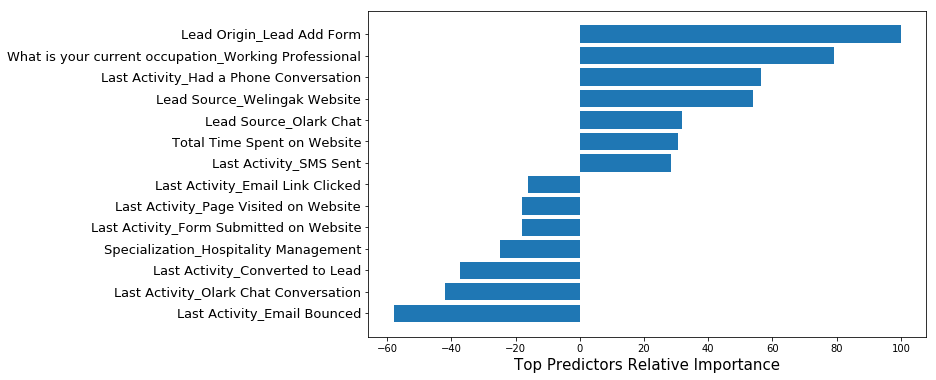

In [100]:
# Plotting the predictors based on their relative importance
top_predictors_sort = np.argsort(top_predictors,kind='quicksort',order='list of str')
fig = plt.figure(figsize = (12,8))
pos = np.arange(top_predictors_sort.shape[0]) + .5

fig1 = plt.figure(figsize=(10,6))
ax = fig1.add_subplot(1, 1, 1)
ax.barh(pos, top_predictors[top_predictors_sort])
ax.set_yticks(pos)
ax.set_yticklabels(np.array(X_train[col_final].columns)[top_predictors_sort], fontsize=13)
ax.set_xlabel('Top Predictors Relative Importance', fontsize=15)
plt.show()

In [98]:
# https://www.kaggle.com/code/amritachatterjee09/lead-scoring-a-logistic-regression-study
# https://www.kaggle.com/code/gauravduttakiit/lead-scoring-with-logistic-regression#Feature-Selection-Using-RFE

In [101]:
from sklearn.model_selection import cross_val_score
model = logreg
scores = cross_val_score(model, X_train, y_train, cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

# compute Average cross-validation score
print('')
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Cross-validation scores:[0.79783951 0.81635802 0.80216383 0.80061824 0.81452859 0.812983
 0.78482972 0.80804954 0.80804954 0.80804954]

Average cross-validation score: 0.8053
